# LiOH ~ oo-pUCCD ~ 300min

In [1]:
'''
Dal NIST:
https://cccbdb.nist.gov/exp2x.asp?casno=1310663&charge=0
Atom	x (Å)	 y (Å)    z (Å)
O1	   0.0000   0.0000	 0.0000
Li2	   0.0000   0.0000	-1.5816
H3	   0.0000   0.0000	 0.9691

Parrebbe lineare, uso le stesse proporzioni?

d_Li_O : d_O_H = 1.5816 : 0.9691 
'''


'\nDal NIST:\nhttps://cccbdb.nist.gov/exp2x.asp?casno=1310663&charge=0\nAtom\tx (Å)\t y (Å)    z (Å)\nO1\t   0.0000   0.0000\t 0.0000\nLi2\t   0.0000   0.0000\t-1.5816\nH3\t   0.0000   0.0000\t 0.9691\n\nParrebbe lineare, uso le stesse proporzioni?\n\nd_Li_O : d_O_H = 1.5816 : 0.9691 \n'

In [2]:
from functools import partial 
from time import time
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci, ci

from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.6691, 1.2691, 0.15) # così 4 punti passanti da 0.9691
# (0.40, 2.15, 0.35) così sono 5 punti 

arr_ground_energy = {
    'FCI': [],
    'pUCCD': [],
    'oo-pUCCD': []
}
basis = 'sto3g'

arr_results = []
arr_partial_energies = []
arr_interpreted = []

# proporzione distanze Li-O e O-H
k_prop = 1.5816 / 0.9691

# con distance si indicherà la distanza tra O e H, in modo che: |d_Li_O| = k_prop * d_O_H

# 1 punto ~ SLSQP(ftol=1E-03, tol=1E-04, eps=1.5E-05) ~ 22min ~ oo maggiore di puccd ❌
## con lo starting point giusto 22->4 si abbassa molto il tempo ma non ci siamo ancora con l''energia
# 1 punto ~ SLSQP(ftol=1E-07, tol=1E-07, eps=1.5E-08) ~ 250min ~ oo minore di puccd ✅
## pUCCD: -81.78025204562572 & time: 262 | oo-pUCCD: -81.78147865571265 & time: 14665
# 4 punti ~ SLSQP(ftol=1E-06, tol=1E-06, eps=1.5E-06) ~ il computer ha ceduto dopo >500min
# 4 punti ~ SLSQP(ftol=1E-06, tol=1E-06, eps=1.5E-06) ~ 295min


In [3]:
import math
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
# freeze di 1s di Li e O e 2s di O -> 3 in totale
# punto di partenza degli optimizer (3 frozen -> 28 params)
oo_starting_point = [-3.14159265e+00,  2.57132717e-04,  5.17226084e-04, -5.86804248e-05,
                     -2.71974090e-06,  1.11636858e-02,  2.46486716e-03, -3.27716892e-02,
                      2.94305485e-03,  3.68683689e-02,  3.14159265e+00, -2.08476273e-04,
                      3.14159265e+00,  4.36616806e-05,  1.12504840e-03,  7.02501568e-02,
                      3.14159265e+00, -2.16521163e-05, -8.03838964e-02,  4.84698736e-04,
                      3.63139878e-01, -8.14129034e-02, -6.72040907e-02, -3.14860570e-03,
                     -2.35170911e-04, -4.08489708e-04,  2.11568309e-04,  6.79869152e-02]

# punto di partenza degli optimizer (4 frozen -> 21 params)
'''
oo_starting_point = [-7.58321288e-04,  3.98108307e-04, -2.18859209e-02,  2.28695998e-03,
                      2.83793558e-03, -7.84804961e-04,  2.81675976e-01, -1.91824079e-02,
                      4.40306770e-03, -1.38996003e-01,  3.14159265e+00, -4.76745013e-02,
                      3.14159265e+00,  2.82699281e-01,  7.64004533e-03,  1.03133018e-01,
                      2.99125664e+00,  3.61295163e-02,  1.59797539e-02, -7.34882474e-02,
                     -9.89758680e-02 ]
'''

# t optimal point (3 frozen -> 15 params)

puccd_starting_point = [ 3.14005977, -3.13716618,  3.13982519,  3.14159265,  3.05133669,
                        -3.14159265,  3.14159265, -0.00535579,  3.11999993, -3.12838782,
                        -3.14051746,  3.13347565, -0.09183282,  3.14159265, -3.14159265 ]

# t optimal point (4 frozen -> 10 params)
'''
puccd_starting_point = [ 3.14159265, -3.14159265,  3.13995847,  3.12377162,  3.14159265,
                        -2.69397638,  3.08970628, -0.05178523,  3.14159265, -3.14159265]
'''
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM
# scelta dell'optimizer
opt = SLSQP(ftol=1E-06, tol=1E-06, eps=1.5E-06)

# HACK: provo una distanza sola: la configurazione di minimo 
for distance in arr_distance:
    # distance = 0.9691

    # definisco un array per contenere le energie parziali a questa distanza
    par_en = []

    print('- - - - - - - - - - - -', distance, '- - - - - - - - - - - -')
    # 0: FCI

    # distanze mantenendo le proporzioni
    d_Li_O = k_prop * distance

    LiOH = "Li .0 .0 " + str(-d_Li_O) + "; O .0 .0 .0 ; " + "H .0 .0 " + str(distance)

    mol = gto.M(
        atom=LiOH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=False,
        verbose=0,
        unit='Angstrom'
    )

    frozen_orbitals = [0,1,2] # per congelare i primi tre orbitali

    e_FCI, one_electron_integrals, two_electron_integrals = compute_fci_energy_and_integrals(mol, frozen_orbitals)

    arr_ground_energy['FCI'].append(e_FCI)
    print('FCI: ', e_FCI)

    '''
    ora in teoria questi passaggi li ho assorbiti in compute_fci_energy_and_integrals()
    '''
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere

    n_frozen_orbitals = 3 # per congelare i primi due orbitali

    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel()[0]
    #e_FCI = fci_calc.kernel(frozen=[0,1,2])[0] # calcola FCI congelando n orbitali

    arr_ground_energy['FCI'].append(e_FCI)
    print('FCI vera: ', e_FCI)
    '''
    two_electron_integrals = mol.intor('int2e') # , aosym='s8') opzioni di simmetria
    one_electron_integrals = mol.intor("int1e_kin") + mol.intor("int1e_nuc")

    # avendo congelato i primi due orbitali, vanno modificati gli integrali elettronici
    # è sufficiente escludere i primi due indici in tutte le dimensioni:
    # (inizio congelandone 4)
    one_electron_integrals = one_electron_integrals[3:, 3:]
    two_electron_integrals = two_electron_integrals[3:, 3:, 3:, 3:]

    '''

    # 1: pUCCD
    problem = generate_problem(LiOH, basis)
    # Freeze first orbital
    freezer = FreezeCoreTransformer(remove_orbitals=[0,1,2]) # (inizio congelandone 3)
    problem = freezer.transform(problem)

    puccd = generate_puccd(problem) 
    # CHECK
    print('orbitals: ', problem.num_spatial_orbitals)
    print('qubits: ', puccd.num_qubits)

    start_time = time()
    puccd_result = compute_puccd_optimal(puccd, problem, ini=puccd_starting_point, opt=opt) 
    eval_time  = time() - start_time 
    # store optimal point for next distance 
    puccd_starting_point = puccd_result.optimal_point
    # and assign parameters
    assigned_puccd = puccd.assign_parameters(puccd_result.optimal_parameters)
    puccd_interpreted = problem.interpret(puccd_result)
    shift = puccd_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    puccd_energy = puccd_interpreted.groundenergy + puccd_interpreted.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(puccd_energy)

    print('pUCCD: ', puccd_energy, ' | eval time: ', eval_time)

    # 2: oo-pUCCD
    rotations = create_orbital_rotation_list(puccd)
    excitations = convert_rotations_list(rotations)
    oo_puccd = generate_oo_puccd(assigned_puccd, problem, excitations)

    # SOLVE
    vqe_solver = VQE(Estimator(), oo_puccd, opt)

    energy_evaluation = partial(energy_evaluation_oo, 
                                problem, 
                                one_electron_integrals,
                                two_electron_integrals,
                                vqe_solver, 
                                rotations, 
                                0,
                                par_en)

    vqe_solver.initial_point = oo_starting_point

    # setto bounds default
    bounds = [ [-np.pi,np.pi] for _ in range(oo_puccd.num_parameters) ]

    print('Inizio minimizzazione')

    start_time = time()

    # minimization
    opt_result = vqe_solver.optimizer.minimize(
        fun=energy_evaluation, x0=oo_starting_point, bounds=bounds
    )
        
    eval_time = time() - start_time

    result = VQEResult()
    result.optimal_point = opt_result.x
    result.optimal_parameters = dict(zip(vqe_solver.ansatz.parameters, opt_result.x))
    result.optimal_value = opt_result.fun
    result.cost_function_evals = opt_result.nfev
    result.optimizer_time = eval_time
    result.eigenvalue = opt_result.fun + 0j

    oo_interpreted = problem.interpret(result)
    shift = oo_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    oo_energy = oo_interpreted.groundenergy + oo_interpreted.nuclear_repulsion_energy + shift

    arr_ground_energy['oo-pUCCD'].append(oo_energy)

    print('oo-pUCCD: ', oo_energy, ' | eval time: ', eval_time)

    # immagazzino tutto
    oo_starting_point = result.optimal_point
    starting_point = opt_result.x
    arr_results.append(result)
    arr_interpreted.append(oo_interpreted)
    arr_partial_energies.append(par_en)

- - - - - - - - - - - - 0.6691 - - - - - - - - - - - -
numero elettroni:
 totale:  12
freezati:  6 
 attivi:  6
FCI:  -21.12540362236038
FCI vera:  -81.4447867303035
orbitals:  8
qubits:  16
pUCCD:  -81.40267488253033  | eval time:  155.49558901786804
Inizio minimizzazione


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_1261/3221578238.py:129: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), oo_puccd, opt)


oo-pUCCD:  -81.40328262185643  | eval time:  6506.5137639045715
- - - - - - - - - - - - 0.8191 - - - - - - - - - - - -
numero elettroni:
 totale:  12
freezati:  6 
 attivi:  6
FCI:  -22.480439888769975
FCI vera:  -81.7986690049783
orbitals:  8
qubits:  16
pUCCD:  -81.7386669846364  | eval time:  206.04889702796936
Inizio minimizzazione
oo-pUCCD:  -81.73963111809617  | eval time:  6407.529155731201
- - - - - - - - - - - - 0.9691000000000001 - - - - - - - - - - - -
numero elettroni:
 totale:  12
freezati:  6 
 attivi:  6
FCI:  -23.23153672274443
FCI vera:  -81.8510378030354
orbitals:  8
qubits:  16
pUCCD:  -81.78036242559205  | eval time:  134.6906340122223
Inizio minimizzazione
oo-pUCCD:  -81.78179764260533  | eval time:  1343.8654787540436
- - - - - - - - - - - - 1.1191 - - - - - - - - - - - -
numero elettroni:
 totale:  12
freezati:  6 
 attivi:  6
FCI:  -23.734649792385255
FCI vera:  -81.80302735509804
orbitals:  8
qubits:  16
pUCCD:  -81.71887795777342  | eval time:  172.41413307189

In [4]:
oo_starting_point

array([-3.14158905e+00,  6.25117106e-03, -5.94990710e-04,  5.67523704e-03,
        4.59306088e-04,  1.77338546e-02, -5.60356359e-04,  1.06728509e-01,
        1.75638448e-02, -3.65172392e-02,  3.14159265e+00, -1.21399379e-02,
        3.14133755e+00, -2.38552986e-03, -7.84179002e-03, -8.08755818e-02,
        3.14044436e+00,  6.62226191e-04, -2.61525452e+00,  3.63201723e-02,
        2.96820599e-01,  4.77682415e-02, -1.02366605e-01, -2.99699480e-01,
       -7.39460376e-03, -3.65320651e-02,  5.28002241e-03, -2.34424153e-01])

In [7]:
# provvisorio: ho messo 2 fci nel met alla volta
arr_fci_false = [en for en in arr_ground_energy['FCI'] if en > -30]
arr_fci = [en for en in arr_ground_energy['FCI'] if en < -30]
arr_ground_energy['FCI'] = arr_fci

# GRAFICO ZOOM

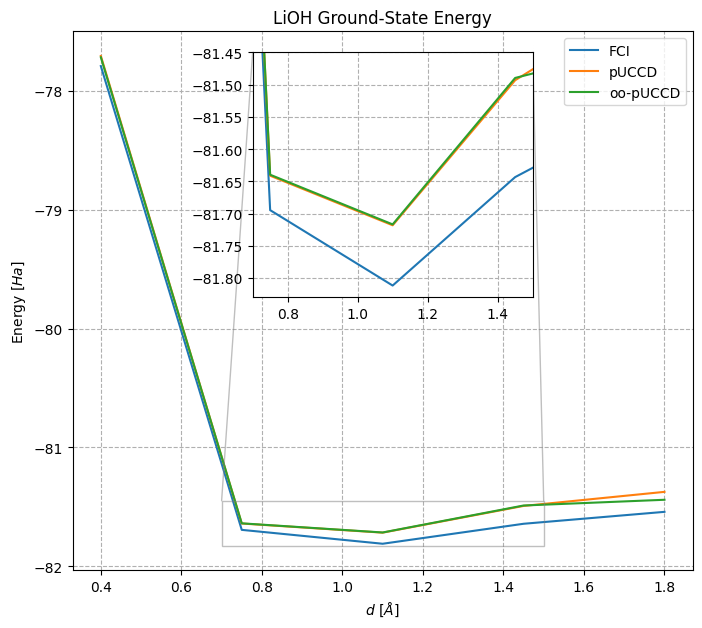

In [66]:
method = ['FCI', 'pUCCD', 'oo-pUCCD']

# Zoom sul minimo 1.25<x<1.8 e -7.9<y<-7.85
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiOH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.35, .5, .35, .35]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=0.7,xmax=1.5)
ax_inset.axis(ymin=-81.83,ymax=-81.45)

for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met)


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()

# GRAFICI CONVERGENZA

Dei tre punti centrali: 0.75, 1.1, 1.45

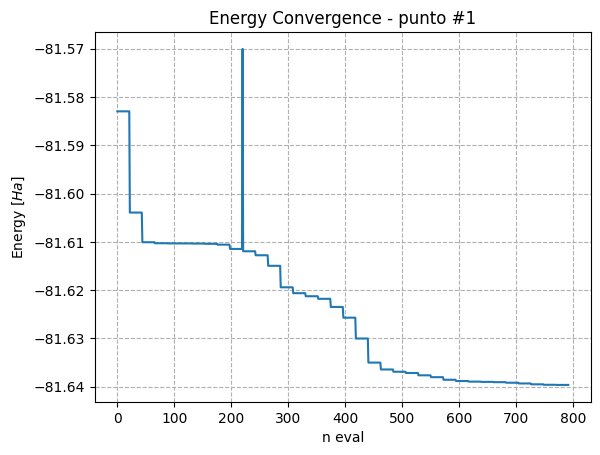

In [71]:
# shifto le energie parziali con nuclear repulsion e acrive space
repulsion = arr_interpreted[1].nuclear_repulsion_energy
frozen_core = arr_interpreted[1].extracted_transformer_energies.get("FreezeCoreTransformer", 0)

shiftato = [x + repulsion + frozen_core for x in arr_partial_energies[1]]

plt.plot(range(len(arr_partial_energies[1])), shiftato)

plt.title("Energy Convergence - punto #1")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()

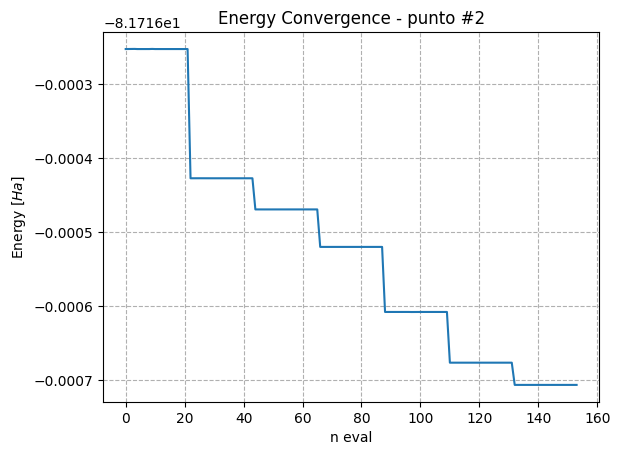

In [72]:
# shifto le energie parziali con nuclear repulsion
repulsion = arr_interpreted[2].nuclear_repulsion_energy
frozen_core = arr_interpreted[2].extracted_transformer_energies.get("FreezeCoreTransformer", 0)

shiftato = [x + repulsion + frozen_core for x in arr_partial_energies[2]]

plt.plot(range(len(arr_partial_energies[2])), shiftato)

plt.title("Energy Convergence - punto #2")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()

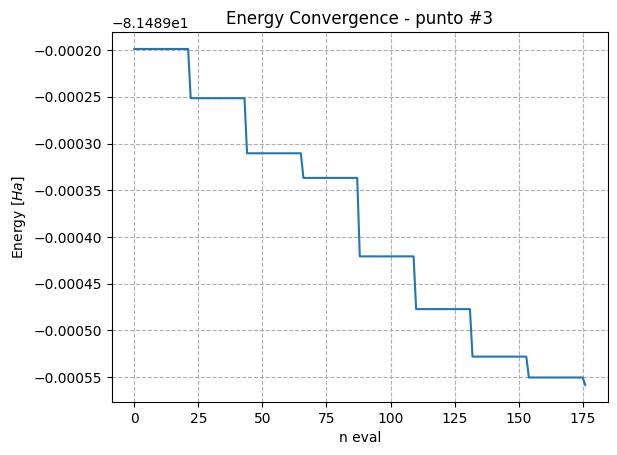

In [73]:
# shifto le energie parziali con nuclear repulsion
repulsion = arr_interpreted[3].nuclear_repulsion_energy
frozen_core = arr_interpreted[3].extracted_transformer_energies.get("FreezeCoreTransformer", 0)

shiftato = [x + repulsion + frozen_core for x in arr_partial_energies[3]]

plt.plot(range(len(arr_partial_energies[3])), shiftato)

plt.title("Energy Convergence - punto #3")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()